In [7]:
#list out all the directories in the current directory
import os
import random
import torch

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [8]:
device

device(type='cuda', index=0)

In [9]:
import numpy as np
from PIL import Image
import os

#randomly sample context_size+target_size images from each class
def get_batch(src, all_classes, num_classes, context_size, target_size):
    batch = {'context_images': [], 'context_labels': [], 'target_images': [], 'target_labels': []}
    sampled_classes = random.sample(all_classes, num_classes)

    for i in range(num_classes):
        class_name = sampled_classes[i]
        class_idx = i
        all_images = os.listdir(os.path.join(src, class_name))
        sampled_images = random.sample(all_images, context_size+target_size)
        context_images = sampled_images[:context_size]
        target_images = sampled_images[context_size:]

        for context_image in context_images:
            image = Image.open(os.path.join(src, class_name, context_image))
            batch['context_images'].append(np.array(image))
            batch['context_labels'].append(class_idx)
        for target_image in target_images:
            image = Image.open(os.path.join(src, class_name, target_image))
            batch['target_images'].append(np.array(image))
            batch['target_labels'].append(class_idx)
    
    batch['context_images'] = np.array(batch['context_images'])
    batch['context_labels'] = np.array(batch['context_labels'])
    batch['target_images'] = np.array(batch['target_images'])
    batch['target_labels'] = np.array(batch['target_labels'])
    return batch  



In [10]:
def show_image(image):
    img_arr = image
    img_acc = Image.fromarray(img_arr)
    img_acc.show() 

In [11]:
import torch
import torch.nn as nn
import torchvision.models as models

class CustomCNN(nn.Module):
    def __init__(self, pretrained_model):
        super(CustomCNN, self).__init__()
        self.backbone = pretrained_model
        # self.softmax= nn.Softmax(dim=1)

    def forward(self, x):
        x = self.backbone(x)
        # x= self.softmax(x)        
        return x

In [12]:
def make_custom_model(num_classes):
    resnet18 = models.resnet18(pretrained=True)

    for param in resnet18.parameters():
        param.requires_grad = False
    
    resnet18.fc = nn.Linear(resnet18.fc.in_features, num_classes)

    for param in resnet18.fc.parameters():
        param.requires_grad = True
    
    model = CustomCNN(resnet18).to(device)
    return model  

In [13]:
def compute_accuracy(outputs, labels):
    # Convert outputs to probabilities using sigmoid
    probs = torch.softmax(outputs, dim=1)
    # Get the class with the highest probability
    _, preds = torch.max(probs, 1)
    # Compare with true labels
    corrects = (preds == labels).float()
    # Calculate accuracy
    accuracy = corrects.sum() / corrects.numel()
    return accuracy

In [14]:
num_tasks = 15
num_epochs = 50

num_classes = 5
context_size = 2
target_size = 10
src = './images'

criterion = nn.CrossEntropyLoss()

context_losses = []
target_losses = []

context_accuracies = []
target_accuracies = []

all_classes = os.listdir(src)
all_classes = [item for item in all_classes if item!='.DS_Store']


context_epoch_accuracies = []
target_epoch_accuracies = []


for i in range(num_tasks):

    current_batch = get_batch(src, all_classes, num_classes, context_size, target_size)

    context_images = torch.tensor(current_batch['context_images'], dtype=torch.float).to(device)
    context_images = context_images.permute(0, 3, 1, 2)
    context_labels = torch.tensor(current_batch['context_labels'], dtype=torch.long).to(device)
    # context_one_hot_labels = torch.nn.functional.one_hot(context_labels, num_classes=num_classes).to(torch.float)
    
    target_images = torch.tensor(current_batch['target_images'], dtype=torch.float).to(device)
    target_images = target_images.permute(0, 3, 1, 2)
    target_labels = torch.tensor(current_batch['target_labels'], dtype=torch.long).to(device)
    # target_one_hot_labels = torch.nn.functional.one_hot(target_labels, num_classes=num_classes).to(torch.float)

    current_model = make_custom_model(num_classes)
    optimizer = torch.optim.Adam(current_model.parameters(), lr=0.001)

    #Training
    current_context_loss = 0
    current_context_accuracy = 0

    current_task_context_accuracies = []
    current_task_target_accuracies = []

    for epoch in range(num_epochs):        
        outputs = current_model(context_images)
        loss = criterion(outputs, context_labels)
        current_context_loss += loss.item()

        accuracy = compute_accuracy(outputs, context_labels)
        current_task_context_accuracies.append(accuracy.item())
        current_context_accuracy += accuracy.item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        current_target_outputs = current_model(target_images)
        current_target_accuracy = compute_accuracy(current_target_outputs, target_labels)
        current_task_target_accuracies.append(current_target_accuracy.item())

        print('Task(Model) {}, Epoch [{}/{}], Context Loss: {:.4f}'.format(i+1,epoch+1,num_epochs,loss.item()))
    
    context_losses.append(current_context_loss/num_epochs)
    context_accuracies.append(current_context_accuracy / num_epochs)

    context_epoch_accuracies.append(current_task_context_accuracies)
    target_epoch_accuracies.append(current_task_target_accuracies)
    
    #Testing
    target_outputs = current_model(target_images)
    target_loss = criterion(target_outputs, target_labels)
    print('Task(Model) {}, Target Loss: {:.4f}'.format(i+1,target_loss.item()))    
    target_losses.append(target_loss.item())   

    target_accuracy = compute_accuracy(target_outputs, target_labels)
    target_accuracies.append(target_accuracy.item())
    


/home/cvig/anaconda3/envs/pml/lib/python3.11/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/cvig/anaconda3/envs/pml/lib/python3.11/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Task(Model) 1, Epoch [1/50], Context Loss: 1.7020
Task(Model) 1, Epoch [2/50], Context Loss: 1.4539
Task(Model) 1, Epoch [3/50], Context Loss: 1.2763
Task(Model) 1, Epoch [4/50], Context Loss: 1.1419
Task(Model) 1, Epoch [5/50], Context Loss: 1.0235
Task(Model) 1, Epoch [6/50], Context Loss: 0.9084
Task(Model) 1, Epoch [7/50], Context Loss: 0.7953
Task(Model) 1, Epoch [8/50], Context Loss: 0.6883
Task(Model) 1, Epoch [9/50], Context Loss: 0.5919
Task(Model) 1, Epoch [10/50], Context Loss: 0.5087
Task(Model) 1, Epoch [11/50], Context Loss: 0.4389
Task(Model) 1, Epoch [12/50], Context Loss: 0.3806
Task(Model) 1, Epoch [13/50], Context Loss: 0.3314
Task(Model) 1, Epoch [14/50], Context Loss: 0.2890
Task(Model) 1, Epoch [15/50], Context Loss: 0.2521
Task(Model) 1, Epoch [16/50], Context Loss: 0.2197
Task(Model) 1, Epoch [17/50], Context Loss: 0.1916
Task(Model) 1, Epoch [18/50], Context Loss: 0.1674
Task(Model) 1, Epoch [19/50], Context Loss: 0.1468
Task(Model) 1, Epoch [20/50], Context Lo

In [15]:
average_context_accuracy = sum(context_accuracies) / len(context_accuracies)
average_target_accuracy = sum(target_accuracies) / len(target_accuracies)

In [16]:
print('Average Context Accuracy: {:.4f}'.format(average_context_accuracy))
print('Average Target Accuracy: {:.4f}'.format(average_target_accuracy))

Average Context Accuracy: 0.9500
Average Target Accuracy: 0.4560


In [17]:
from tueplots import bundles
import matplotlib.pyplot as plt
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update(bundles.beamer_moml())

# Also add despine to the bundle using rcParams
plt.rcParams["axes.spines.right"] = False
plt.rcParams["axes.spines.top"] = False

# Increase font size to match Beamer template
plt.rcParams["font.size"] = 16
# Make background transparent
plt.rcParams["figure.facecolor"] = "none"
# use font size Roboto Condensed
plt.rcParams["font.family"] = "sans-serif"

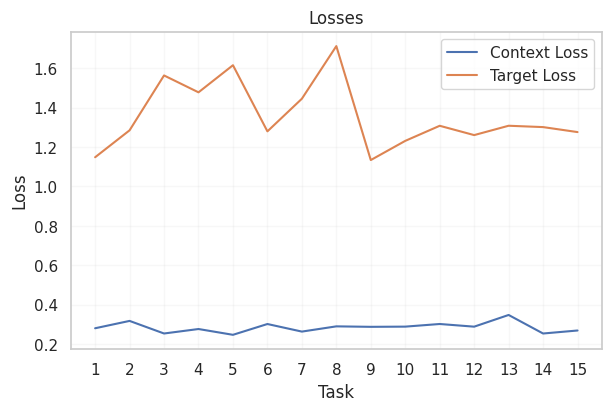

In [18]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.plot(context_losses)
plt.plot(target_losses)
plt.legend(['Context Loss', 'Target Loss'])
plt.xlabel('Task')
plt.ylabel('Loss')
plt.xticks(range(num_tasks), [str(i + 1) for i in range(num_tasks)])
plt.title('Losses')
plt.savefig('losses_celeb10.pdf', bbox_inches='tight', transparent=True)

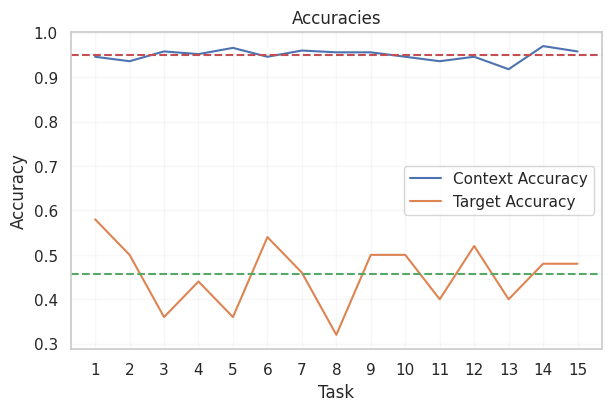

In [19]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.plot(context_accuracies)
plt.plot(target_accuracies)
plt.axhline(y=average_context_accuracy, color='r', linestyle='--')
plt.axhline(y=average_target_accuracy, color='g', linestyle='--')
plt.legend(['Context Accuracy', 'Target Accuracy'])
plt.xlabel('Task')
plt.ylabel('Accuracy')
plt.xticks(range(num_tasks), [str(i + 1) for i in range(num_tasks)])
plt.title('Accuracies')
plt.savefig('accuracies_celeb10.pdf', bbox_inches='tight', transparent=True)


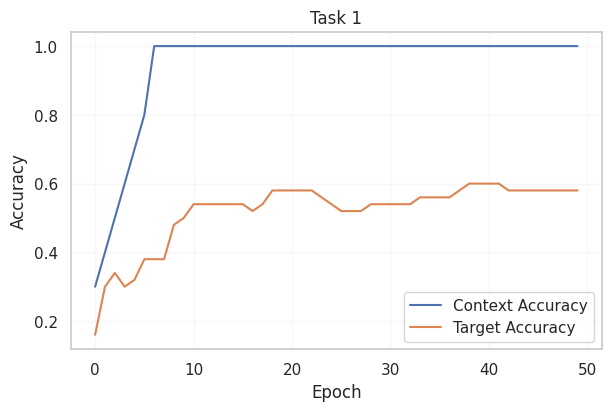

In [20]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.plot(context_epoch_accuracies[0])
plt.plot(target_epoch_accuracies[0])
plt.legend(['Context Accuracy', 'Target Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Task 1')
plt.savefig('task1_celeb10.pdf', bbox_inches='tight', transparent=True)

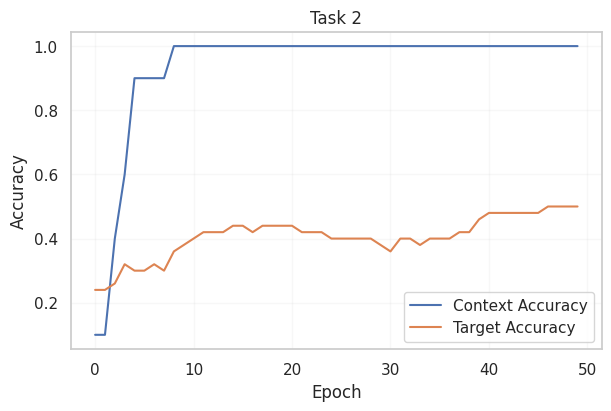

In [21]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.plot(context_epoch_accuracies[1])
plt.plot(target_epoch_accuracies[1])
plt.legend(['Context Accuracy', 'Target Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Task 2')
plt.savefig('task2_celeb10.pdf', bbox_inches='tight', transparent=True)

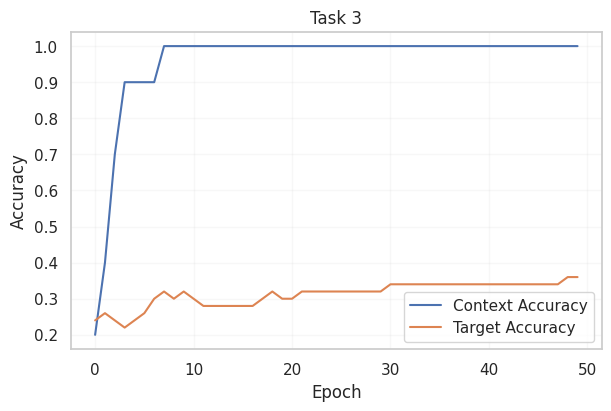

In [22]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
plt.plot(context_epoch_accuracies[2])
plt.plot(target_epoch_accuracies[2])
plt.legend(['Context Accuracy', 'Target Accuracy'])
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Task 3')
plt.savefig('task3_celeb10.pdf', bbox_inches='tight', transparent=True)